Setup and import

In [1]:
import numpy as np
from scipy.optimize import fsolve
from sympy import primepi
import matplotlib.pyplot as plt
import mpmath
import csv
import scipy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.optimize import leastsq
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Equation

In [2]:
def equation(x, a, pi_a):
    argument = a - a / (x * np.pi / 2)
    if argument <= 0:
        return np.nan
    result = pi_a - a / np.log(argument)
    return float(result)


In [3]:
# Define the range and step size for a
a_start = 10**10
a_end =   9*10**10
a_step =  10**10

# Generate values for a
a_values = np.arange(a_start, a_end + a_step, a_step)

# Arrays to hold the results
x_solutions = []
f_values = []
abs_li_minus_pi_values = []
abs_f_minus_pi_values = []

# Compute x for each value of a
prime_pi=[]
index=0
for a in a_values:
    pi_a = primepi(a)
    prime_pi.append(pi_a)
    # Use fsolve to find the root of the equation
    x_initial_guess = 1
    x_solution, = fsolve(equation, x_initial_guess, args=(a, pi_a))
    print(a, x_solution)
    x_solutions.append(x_solution)

    # Calculate the modified f(x) using the solution x
    if x_solution > 0:  # Ensure x_solution is positive
        f_x = a / np.log(a - a / (x_solution * np.pi / 2))
    else:
        f_x = np.nan

    f_values.append(f_x)

    # Calculate Li(x) using mpmath
    li_x = mpmath.li(a)

    abs_li_minus_pi = np.abs(li_x - pi_a)
    abs_f_minus_pi = np.abs(f_x - pi_a)

    abs_li_minus_pi_values.append(abs_li_minus_pi)
    abs_f_minus_pi_values.append(abs_f_minus_pi)


/tmp/ipykernel_4708/3760628940.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(result)


10000000000 0.9791288343029741
20000000000 0.980073878502535
30000000000 0.9805656235254062
40000000000 0.9808806440341503
50000000000 0.9811520026678452
60000000000 0.9813436613658271
70000000000 0.9815136068860326
80000000000 0.9816670252744483
90000000000 0.9818036423366127


In [4]:
# Perform linear regression on x_solutions based on a_values
slope, intercept = np.polyfit(a_values, x_solutions, 1)
print(f"Linear regression equation: x = {slope:.32f} * a + {intercept:.32f}")


Linear regression equation: x = 0.00000000000002972942750537611433 * a + 0.97941674183537896780649134598207


In [5]:
def logarithmic_regression(x, a):
    def model(params, x):
        c, d = params
        return c + d * np.log(x)

    def objective(params, x, y):
        return model(params, x) - y

    # Initial guess for parameters (c, d)
    initial_params = [0, 1]

    # Solve for parameters using nonlinear least squares
    params, _ = scipy.optimize.leastsq(objective, initial_params, args=(x, a))

    return params

# Perform logarithmic regression on x_solutions based on a_values
log_params = logarithmic_regression(a_values, np.array(x_solutions))
log_predictions = log_params[0] + log_params[1] * np.log(a_values)
log_params[1]
print(f"Logarithmic regression equation: x = {log_params[0]:.15f} + {log_params[1]:.15f} * log(a)")

Logarithmic regression equation: x = 0.951561470568547 + 0.001200155888107 * log(a)


Compute R^2 for log predictions

In [6]:
r2_log = r2_score(x_solutions, log_predictions)
print(f"R-squared for Logarithmic Regression: {r2_log:.12f}")

R-squared for Logarithmic Regression: 0.997980187411


Compute Mean Squared Error for the logarithmic regression

In [7]:
# Compute Mean Squared Error for the logarithmic regression
mse_log = mean_squared_error(x_solutions, log_predictions)
print(f"Mean Squared Error for Logarithmic Regression: {mse_log:.12f}")

Mean Squared Error for Logarithmic Regression: 0.000000001341


In [8]:
# Compute Root Mean Squared Error for the logarithmic regression
rmse_log = np.sqrt(mse_log)
print(f"Root Mean Squared Error for Logarithmic Regression: {rmse_log:.12f}")

Root Mean Squared Error for Logarithmic Regression: 0.000036613656


In [9]:
def transformed_function(a, slope, intercept):
    x = slope * a + intercept
    if a - (0.6366197724 * a) / x <= 0:
        return np.nan
    pi=np.pi
    return primepi(a) - (a / np.log(a - (0.6366197724 * a) / x))


In [10]:
def transformed_function_log(a, p1, p2):
    x = p1+ p2*np.log(a)
    if a - (0.6366197724 * a) / x <= 0:
        return np.nan
    pi=np.pi
    return primepi(a) - (a / np.log(a - (0.6366197724 * a) / x))

In [11]:
transformed_values = [transformed_function(a, slope, intercept) for a in a_values]
transformed_values_log = [transformed_function_log(a, log_params[0], log_params[1]) for a in a_values]

The equation of the fitted quadratic polynomial is: y = 72332.67713268715306185185909271240234 + -0.00000516022262644012072490195750*x + 0.00000000000000005847407248075337*x^2
Mean Squared Error: 5536130.18802604
R-squared: 0.9962855944694529
Mean Squared Error: 5200075.97491976
R-squared: 0.7652918615082986


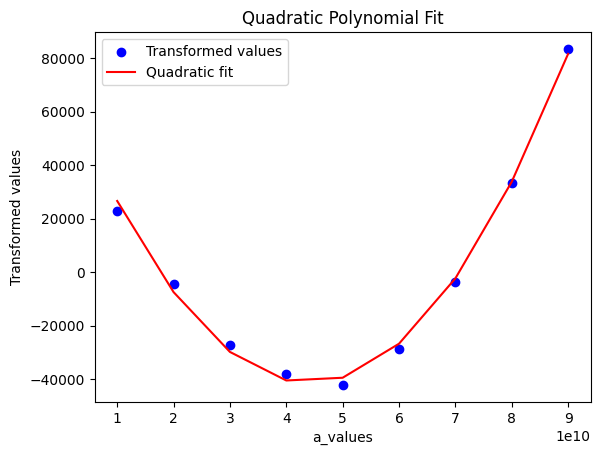

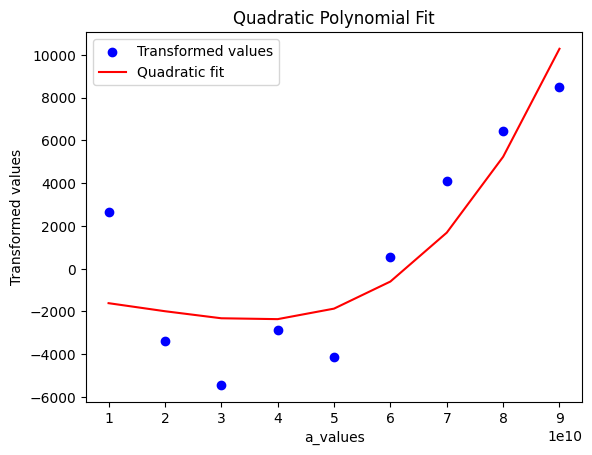

In [12]:
X = a_values.reshape(-1, 1)

# Create quadratic features (x and x^2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Fit the model
model = LinearRegression()
model.fit(X_poly, transformed_values)

# Predict the transformed values
y_pred = model.predict(X_poly)

#fit log

poly3 = PolynomialFeatures(degree=3)
X_poly = poly3.fit_transform(X)

# Fit the model
model2 = LinearRegression()

model2.fit(X_poly, transformed_values_log)

# Predict the transformed values
y_pred2 = model2.predict(X_poly)

# Evaluate the model
mse = mean_squared_error(transformed_values, y_pred)
r2 = r2_score(transformed_values, y_pred)
beta_0 = model.intercept_  # Intercept (β_0)
beta_1, beta_2 = model.coef_[1:]  # Coefficients for x and x^2 (β_1 and β_2)

# Print the quadratic equation
print(f"The equation of the fitted quadratic polynomial is: y = {beta_0:.32f} + {beta_1:.32f}*x + {beta_2:.32f}*x^2")

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")



mse = mean_squared_error(transformed_values_log, y_pred2)
r2 = r2_score(transformed_values_log, y_pred2)
#beta_0 = model2.intercept_  # Intercept (β_0)
#beta_1, beta_2 = model.coef_[1:]

#print(f"The equation of the fitted quadratic polynomial is: y = {beta_0:.32f} + {beta_1:.32f}*x + {beta_2:.32f}*x^2")

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot the results
plt.scatter(a_values, transformed_values, color='blue', label='Transformed values')
plt.plot(a_values, y_pred, color='red', label='Quadratic fit')
plt.xlabel('a_values')
plt.ylabel('Transformed values')
plt.title('Quadratic Polynomial Fit')
plt.legend()
plt.show()

plt.scatter(a_values, transformed_values_log, color='blue', label='Transformed values')
plt.plot(a_values, y_pred2, color='red', label='Quadratic fit')
plt.xlabel('a_values')
plt.ylabel('Transformed values')
plt.title('Quadratic Polynomial Fit')
plt.legend()
plt.show()

In [13]:
# Save the results to a CSV file
print(str(a_start))
csv_filename = f"results from {a_start} to {a_end}.csv"
print(csv_filename)
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['a', 'x_solution', 'f(x)', '|Li(x) - pi(x)|', '|f(x) - pi(x)|'])
    for a, x_solution, f_x, li_minus_pi, f_minus_pi in zip(a_values, x_solutions, f_values, abs_li_minus_pi_values, abs_f_minus_pi_values):
        writer.writerow([a, x_solution, f_x, li_minus_pi, f_minus_pi])

print(f"Results saved to {csv_filename}")


10000000000
results from 10000000000 to 90000000000.csv
Results saved to results from 10000000000 to 90000000000.csv


In [14]:
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Number of observations and predictors
n = len(a_values)
p = 1  # Only one predictor in logarithmic regression

adj_r2_log = adjusted_r2(r2_log, n, p)
print(f"Adjusted R-squared for Logarithmic Regression: {adj_r2_log:.32f}")
from scipy import stats
residuals_log = np.array(x_solutions) - np.array(log_predictions)
# Compute F-statistic and p-value
ss_res = np.sum(residuals_log ** 2)
ss_tot = np.sum((np.array(x_solutions) - np.mean(x_solutions)) ** 2)
f_statistic = (ss_tot - ss_res) / p / (ss_res / (n - p - 1))
p_value = 1 - stats.f.cdf(f_statistic, p, n - p - 1)
print(f"R-squared for Logarithmic Regression: {r2_log:.32}")
print(f"Mean Squared Error for Logarithmic Regression: {mse_log:.32}")
print(f"Root Mean Squared Error for Logarithmic Regression: {rmse_log:.32}")
print(f"F-statistic for Logarithmic Regression: {f_statistic:.32}")
print(f"P-value for F-statistic: {p_value:.32f}")

Adjusted R-squared for Logarithmic Regression: 0.99769164275518529283459656653577
R-squared for Logarithmic Regression: 0.99798018741078708959690857227542
Mean Squared Error for Logarithmic Regression: 1.3405598086565231850352035054288e-09
Root Mean Squared Error for Logarithmic Regression: 3.6613656040561193630040320856622e-05
F-statistic for Logarithmic Regression: 3458.6680710796122184547130018473
P-value for F-statistic: 0.00000000010786049831068567073089


In [15]:
print(f"Logarithmic regression equation: x = {log_params[0]:.32f} + {log_params[1]:.32f} * log(a)")

"""Compute R^2 for log predictions"""

r2_log = r2_score(x_solutions, log_predictions)
print(f"R-squared for Logarithmic Regression: {r2_log:.32f}")

"""Compute Mean Squared Error for the logarithmic regression"""

# Compute Mean Squared Error for the logarithmic regression
mse_log = mean_squared_error(x_solutions, log_predictions)
print(f"Mean Squared Error for Logarithmic Regression: {mse_log:.32f}")

# Compute Root Mean Squared Error for the logarithmic regression
rmse_log = np.sqrt(mse_log)
print(f"Root Mean Squared Error for Logarithmic Regression: {rmse_log:.32f}")

Logarithmic regression equation: x = 0.95156147056854700760908372103586 + 0.00120015588810690946967862924311 * log(a)
R-squared for Logarithmic Regression: 0.99798018741078708959690857227542
Mean Squared Error for Logarithmic Regression: 0.00000000134055980865652318503520
Root Mean Squared Error for Logarithmic Regression: 0.00003661365604056119363004032086


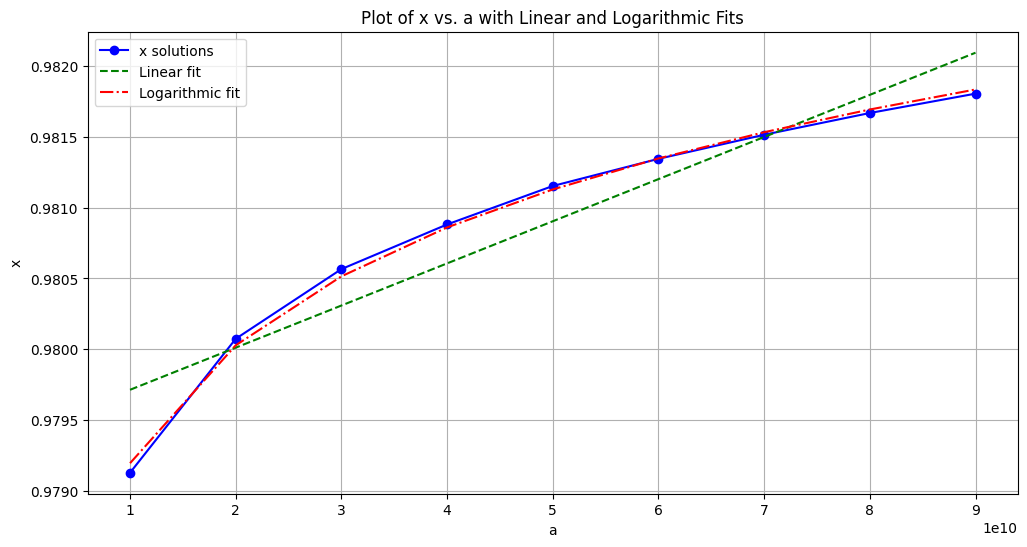

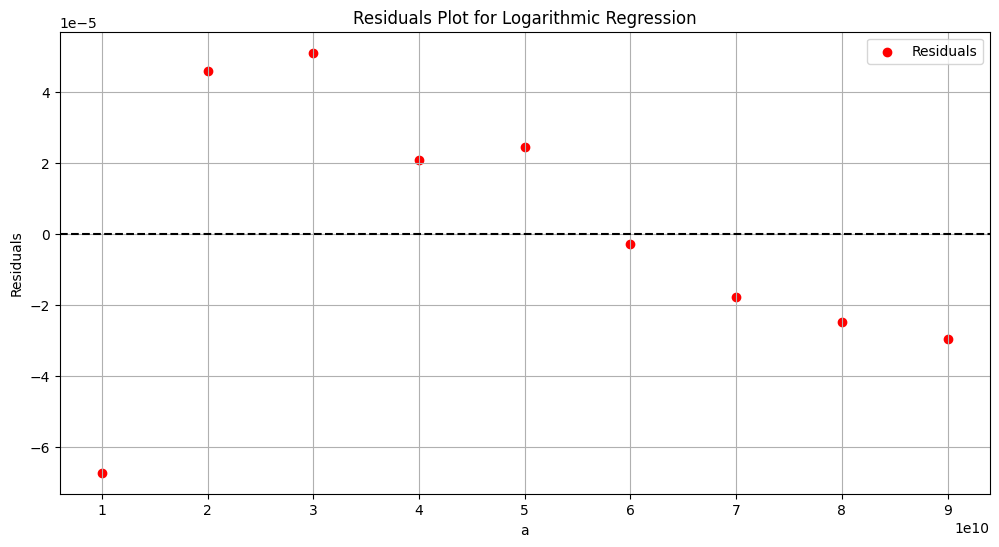

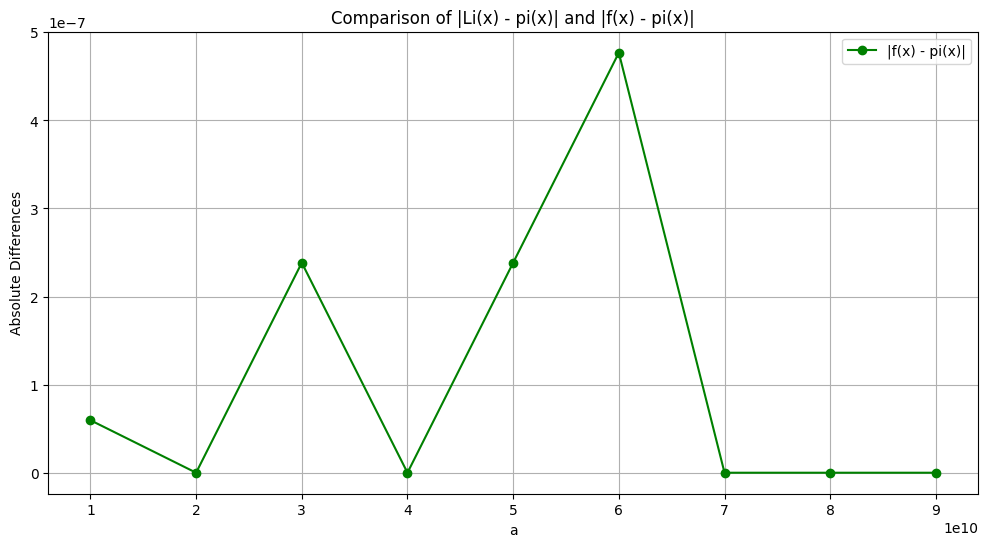

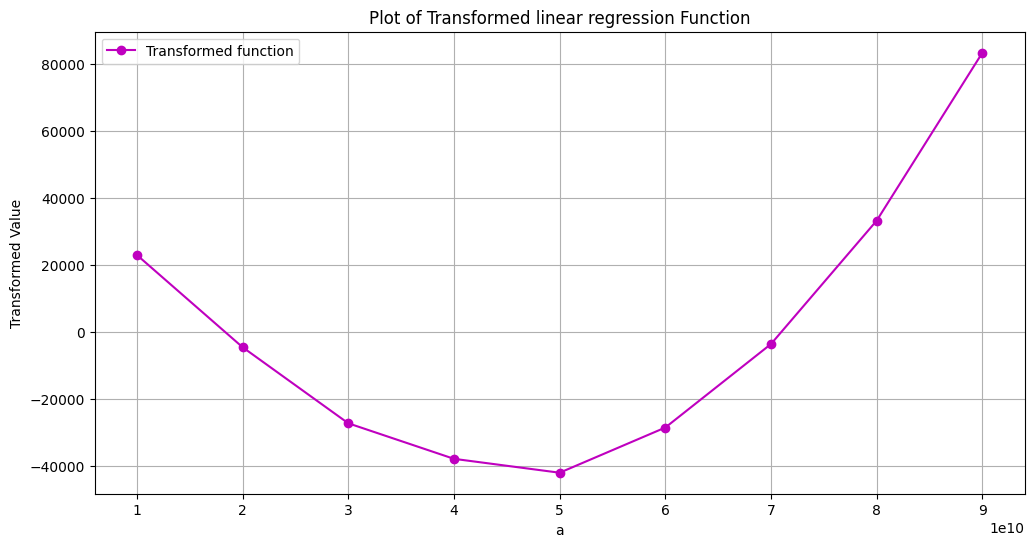

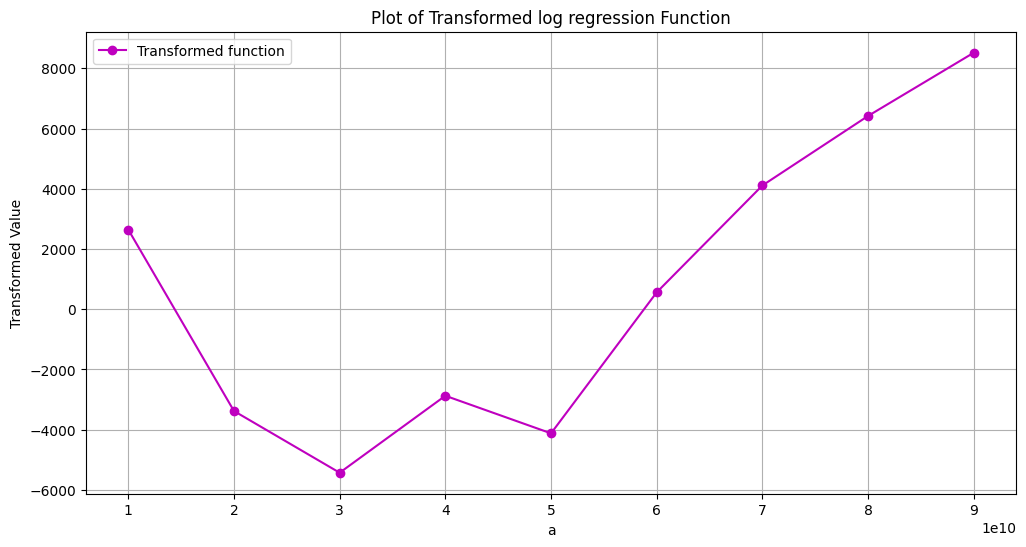

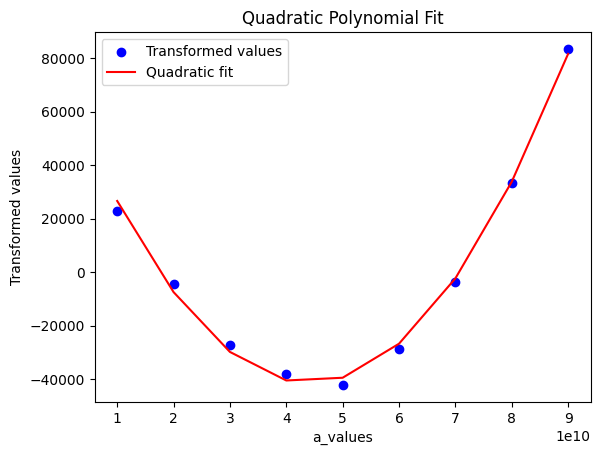

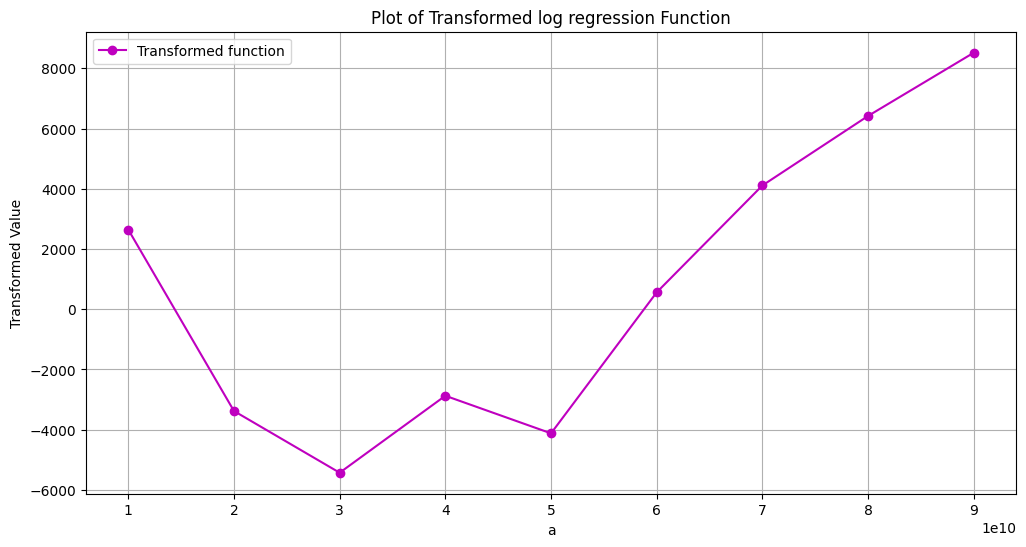

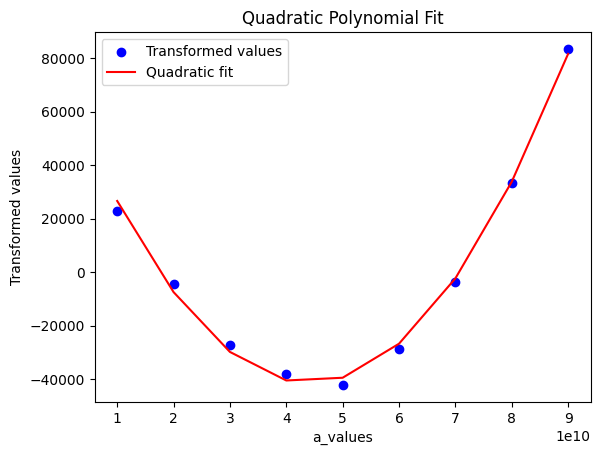

In [16]:

# Plot the linear regression line
plt.figure(figsize=(12, 6))
plt.plot(a_values, x_solutions, marker='o', linestyle='-', color='b', label='x solutions')
plt.plot(a_values, slope * a_values + intercept, linestyle='--', color='g', label='Linear fit')
plt.plot(a_values, log_predictions, linestyle='-.', color='r', label='Logarithmic fit')
plt.xlabel('a')
plt.ylabel('x')
plt.title('Plot of x vs. a with Linear and Logarithmic Fits')
plt.legend()
plt.grid(True)
plt.show()

# Compute residuals
residuals_log = np.array(x_solutions) - np.array(log_predictions)

# Plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(a_values, residuals_log, marker='o',linestyle='-', color='r', label='Residuals')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('a')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Logarithmic Regression')
plt.legend()
plt.grid(True)
plt.show()


# Plotting |Li(x) - pi(x)| and |f(x) - pi(x)| on the same graph
plt.figure(figsize=(12, 6))
#plt.plot(a_values, abs_li_minus_pi_values, marker='o', linestyle='-', color='r', label='|Li(x) - pi(x)|')
plt.plot(a_values, abs_f_minus_pi_values, marker='o', linestyle='-', color='g', label='|f(x) - pi(x)|')
plt.xlabel('a')
plt.ylabel('Absolute Differences')
plt.title('Comparison of |Li(x) - pi(x)| and |f(x) - pi(x)|')
plt.legend()
plt.grid(True)
plt.show()

# Plot the transformed function
plt.figure(figsize=(12, 6))
plt.plot(a_values, transformed_values, marker='o', linestyle='-', color='m', label='Transformed function')
plt.xlabel('a')
plt.ylabel('Transformed Value')
plt.title('Plot of Transformed linear regression Function')
plt.grid(True)
plt.legend()
plt.show()



plt.figure(figsize=(12, 6))
plt.plot(a_values, transformed_values_log, marker='o', linestyle='-', color='m', label='Transformed function')
plt.xlabel('a')
plt.ylabel('Transformed Value')
plt.title('Plot of Transformed log regression Function')
plt.grid(True)
plt.legend()
plt.show()
plt.scatter(a_values, transformed_values, color='blue', label='Transformed values')
plt.plot(a_values, y_pred, color='red', label='Quadratic fit')
plt.xlabel('a_values')
plt.ylabel('Transformed values')
plt.title('Quadratic Polynomial Fit')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(a_values, transformed_values_log, marker='o', linestyle='-', color='m', label='Transformed function')
plt.xlabel('a')
plt.ylabel('Transformed Value')
plt.title('Plot of Transformed log regression Function')
plt.grid(True)
plt.legend()
plt.show()
plt.scatter(a_values, transformed_values, color='blue', label='Transformed values')
plt.plot(a_values, y_pred, color='red', label='Quadratic fit')
plt.xlabel('a_values')
plt.ylabel('Transformed values')
plt.title('Quadratic Polynomial Fit')
plt.legend()
plt.show()

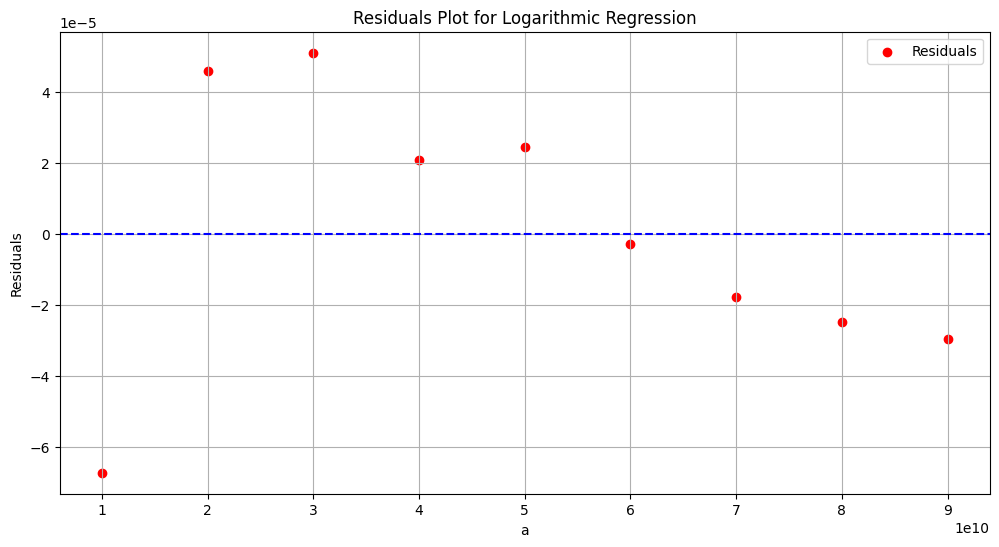

In [17]:
# Compute residuals
residuals_log = np.array(x_solutions) - np.array(log_predictions)

# Plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(a_values, residuals_log, marker='o',linestyle='-', color='r', label='Residuals')
plt.axhline(y=0, color='b', linestyle='--')
plt.xlabel('a')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Logarithmic Regression')
plt.legend()
plt.grid(True)
plt.show()

3.1 3.0 11.0
3.2 3.0 11.0
3.3 3.0 11.0
3.4 3.0 11.0
3.5 3.0 11.0
3.6 3.0 11.0
3.7 3.0 11.0
3.8 3.0 11.0
3.9 3.0 11.0


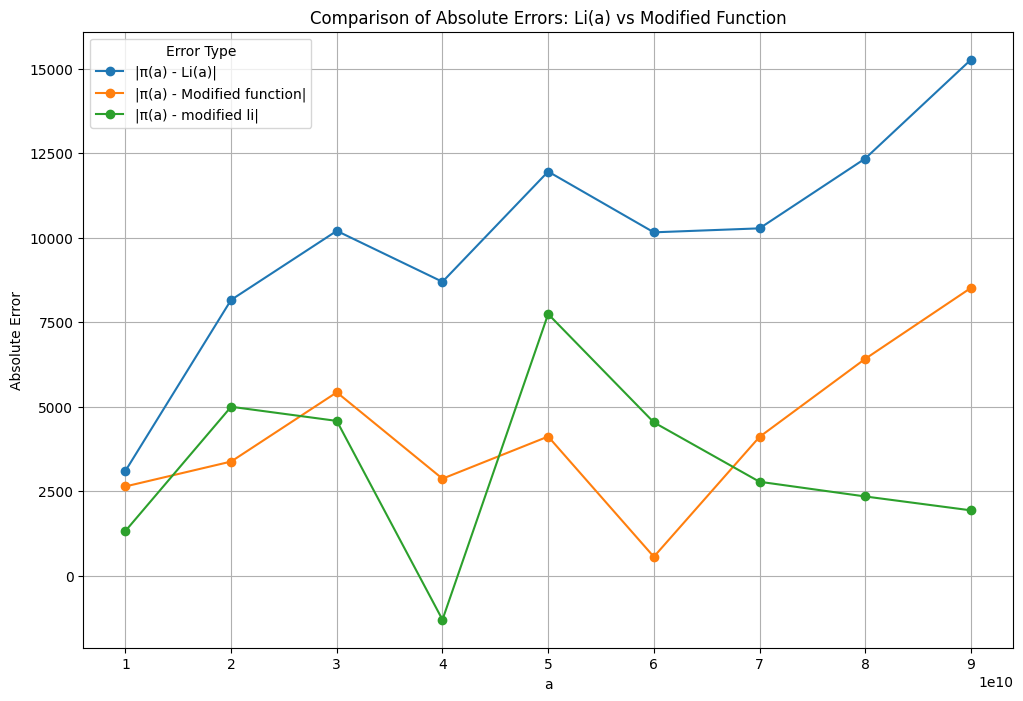

In [24]:
import mpmath

# Define the logarithmic integral function
def li(x):
    return mpmath.li(x)

def most_left_digit_math(num):
    num = abs(num)  # Work with the absolute value
    while num >= 10:
        num //= 10  # Integer division by 10
    return int(num) 

# Define the modified function based on your previous code
def modified_function2(a, rg):
    argument = a - a / (rg * np.pi / 2)
    if argument <= 0:
        return np.nan
    return  (a / np.log(argument))

# Arrays to hold the results
li_errors = []
mod_errors = []
diff_li=[]
li_errors2=[]
# Use your computed regression factor


# Compute errors for each value of x
index=0
for a, x in zip(a_values, x_solutions):
    pi_x = prime_pi[index]
    li_x = li(a)
    rg = log_params[0] + log_params[1] * np.log(a)
    mod_x = modified_function2(a, rg)
    #xlnx=a/(np.log(a))
    #diff_li.append(li_x-xlnx)
    first_digit=most_left_digit_math(a)
    minus_num=np.floor((np.floor(np.log10(a))+1)/3)#np.floor(np.log10(a)-2)
    print(minus_num+first_digit/10,minus_num,np.floor(np.log10(a)+1))
    """if first_digit==1:
        li_errors2.append(li_x-pi_x-10**(minus_num+first_digit/20))"""
    if first_digit>4:
        li_errors2.append(li_x-pi_x-10**(minus_num+first_digit/8))
    else:
        li_errors2.append(li_x-pi_x-10**(minus_num+first_digit/4))
    li_errors.append(li_x-pi_x)
    mod_errors.append(abs(pi_x - mod_x))
    index+=1
# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(a_values, li_errors,marker="o", label='|π(a) - Li(a)|')
plt.plot(a_values, mod_errors,marker="o", label='|π(a) - Modified function|')
plt.plot(a_values, li_errors2,marker="o", label='|π(a) - modified li|')

plt.title('Comparison of Absolute Errors: Li(a) vs Modified Function')
plt.xlabel('a')
plt.ylabel('Absolute Error')
plt.legend(title='Error Type')
plt.grid(True)

# Save the plot as a PNG file
plt.savefig(f'error_comparison_plot {a_start} to {a_end}.png', dpi=300, bbox_inches='tight')

# Display the plot (optional, if you're running this in an environment that can show plots)
plt.show()

R-squared: 0.29546670447632895
Mean Squared Error: 3379307.98256015
Root Mean Squared Error: 1838.289417518403
Linear Regression Equation: y = 1922.25848081045660364907234907150269 + 0.00000004610659278492133761607590 * x


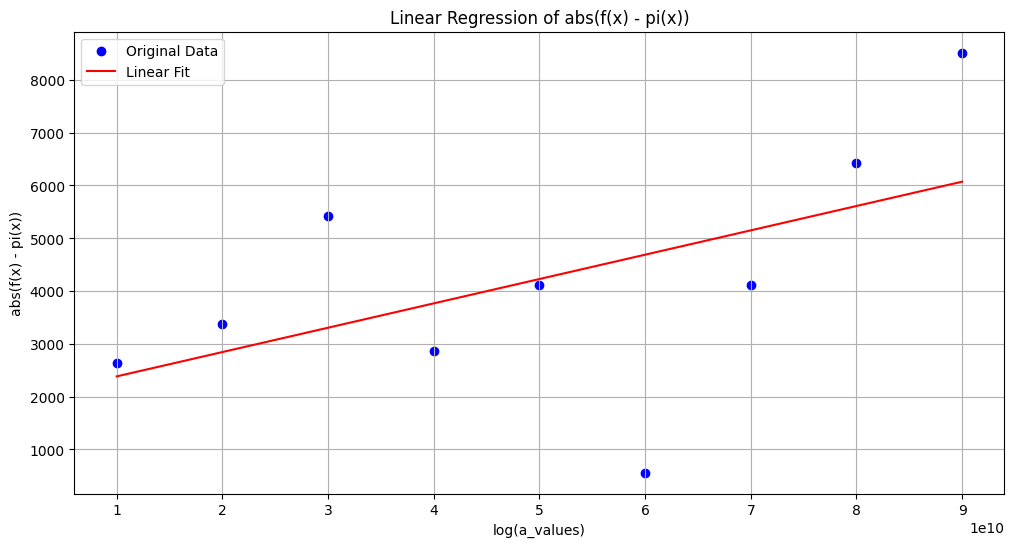

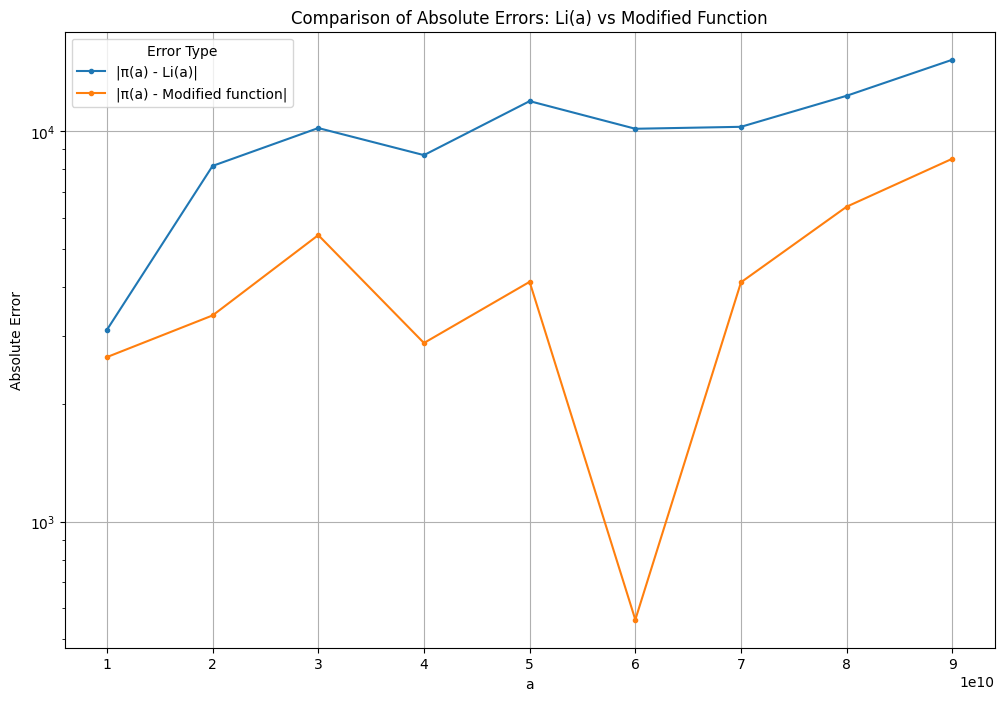

In [19]:


# Transform a_values to log scale and reshape for sklearn
log_a_values=a_values.reshape(-1, 1)
# Ensure that abs(f(x) - pi(x)) is in a numpy array and reshaped for sklearn
y_values = np.array(mod_errors).reshape(-1, 1)

# Create a LinearRegression model
lin_reg = LinearRegression()

# Fit the model to the log-transformed data
lin_reg.fit(log_a_values, y_values)

# Get the predictions
y_pred = lin_reg.predict(log_a_values)

# Check for NaN or Inf in y_pred
if np.any(np.isnan(y_pred)) or np.any(np.isinf(y_pred)):
    raise ValueError("y_pred contains NaN or Inf values")

# Flatten y_values and y_pred for metrics calculations
y_values = np.ravel(y_values)
y_pred = np.ravel(y_pred)

# Calculate R-squared
r2 = r2_score(y_values, y_pred)
print(f"R-squared: {r2}")

# Calculate Mean Squared Error
mse = mean_squared_error(y_values, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

intercept = lin_reg.intercept_[0]
slope = lin_reg.coef_[0][0]
print(f"Linear Regression Equation: y = {intercept:.32f} + {slope:.32f} * x")

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(log_a_values, y_values, color='blue', label='Original Data')
plt.plot(log_a_values, y_pred, color='red', label='Linear Fit')
plt.xlabel('log(a_values)')
plt.ylabel('abs(f(x) - pi(x))')
plt.title('Linear Regression of abs(f(x) - pi(x))')
plt.legend()
plt.grid(True)



# Create the plot"""
plt.figure(figsize=(12, 8))
plt.semilogy(a_values, li_errors,marker=".", label='|π(a) - Li(a)|')
plt.semilogy(a_values, mod_errors,marker=".", label='|π(a) - Modified function|')


plt.title('Comparison of Absolute Errors: Li(a) vs Modified Function')
plt.xlabel('a')
plt.ylabel('Absolute Error')
plt.legend(title='Error Type')
plt.grid(True)

# Save the plot as a PNG file
plt.savefig('error_comparison_plot ${a_start} to ${a_end} .png', dpi=300, bbox_inches='tight')

# Display the plot (optional, if you're running this in an environment that can show plots)
plt.show()

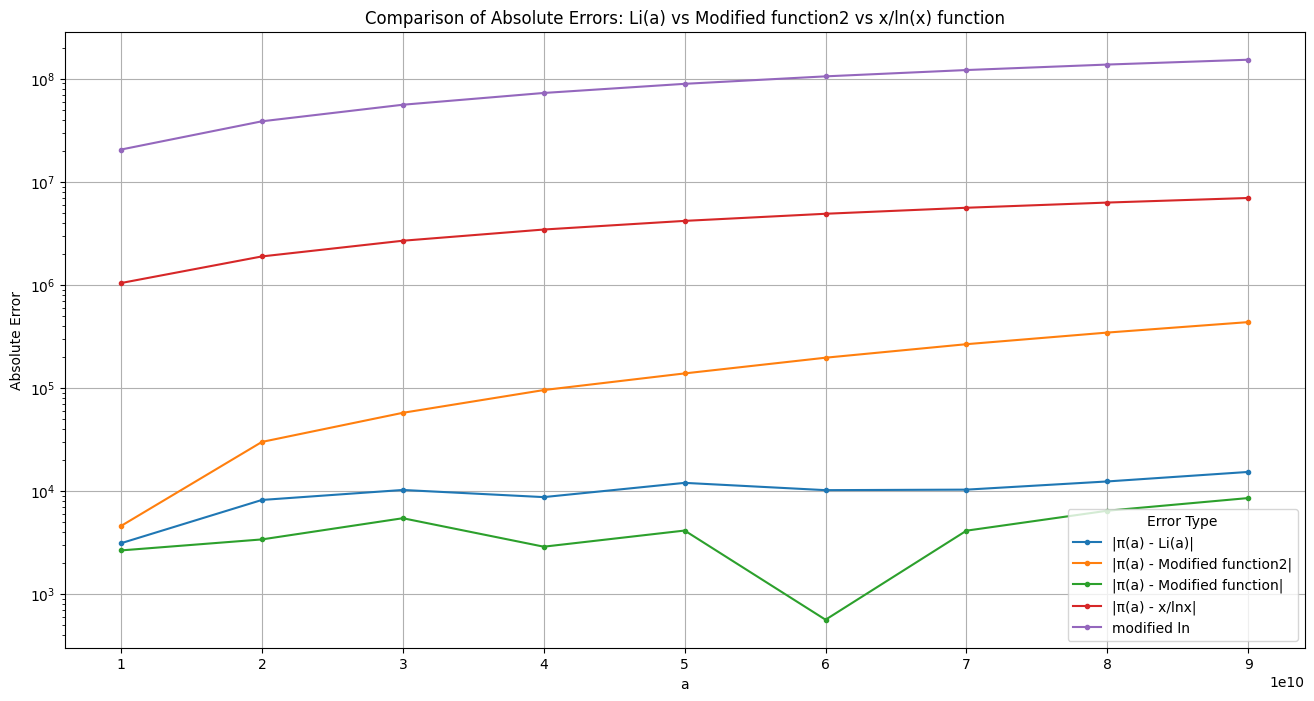

In [20]:
mod_errors2=[]
mod_ln=[]
mod_ln_ln2=[]
index=0


for a, x in zip(a_values, x_solutions):
    pi_x = prime_pi[index]
    rg = log_params[0] + log_params[1] * np.log(a)
    # y = {beta_0:.32f} + {beta_1:.32f}*x + {beta_2:.32f}*x^2")
    rg=0.00000000000002707791861318303864 * a + 0.97951396382809330365404321128153
    mod_x = modified_function2(a, rg)+(beta_0 + beta_1*a + beta_2*a**2)

    mod_errors2.append(abs(pi_x - mod_x))
    lnFunc=a/(np.log(a)-1)
    lnFunc2=a/(np.log(a)-2)
    mod_ln.append(abs(pi_x - lnFunc))
    mod_ln_ln2.append(abs(pi_x - lnFunc2))
    index+=1
plt.figure(figsize=(16, 8))
plt.semilogy(a_values, li_errors,marker='.', label='|π(a) - Li(a)|')
plt.semilogy(a_values, mod_errors2,marker='.', label='|π(a) - Modified function2|')
plt.semilogy(a_values, mod_errors,marker='.', label='|π(a) - Modified function|')
plt.semilogy(a_values, mod_ln,marker=".", label='|π(a) - x/lnx|')
plt.semilogy(a_values, mod_ln_ln2,marker=".", label='modified ln')

plt.title('Comparison of Absolute Errors: Li(a) vs Modified function2 vs x/ln(x) function')
plt.xlabel('a')
plt.ylabel('Absolute Error')
plt.legend(title='Error Type')
plt.grid(True)
# Save the plot as a PNG file
plt.savefig('error_comparison_plot.png', dpi=300, bbox_inches='tight')

# Display the plot (optional, if you're running this in an environment that can show plots)
plt.show()

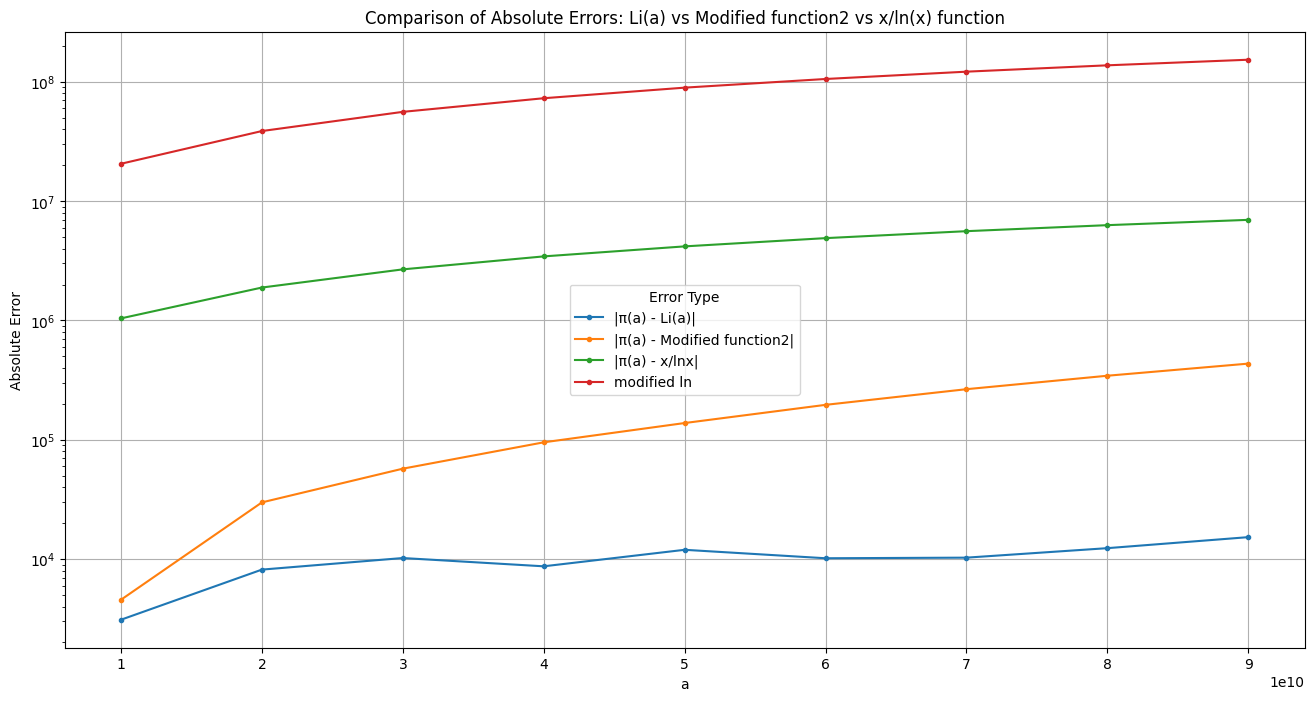

In [21]:
plt.figure(figsize=(16, 8))
plt.semilogy(a_values, li_errors,marker='.', label='|π(a) - Li(a)|')
plt.semilogy(a_values, mod_errors2,marker='.', label='|π(a) - Modified function2|')
plt.semilogy(a_values, mod_ln,marker=".", label='|π(a) - x/lnx|')
plt.semilogy(a_values, mod_ln_ln2,marker=".", label='modified ln')

plt.title('Comparison of Absolute Errors: Li(a) vs Modified function2 vs x/ln(x) function')
plt.xlabel('a')
plt.ylabel('Absolute Error')
plt.legend(title='Error Type')
plt.grid(True)
# Save the plot as a PNG file
plt.savefig('error_comparison_plot.png', dpi=300, bbox_inches='tight')

# Display the plot (optional, if you're running this in an environment that can show plots)
plt.show()

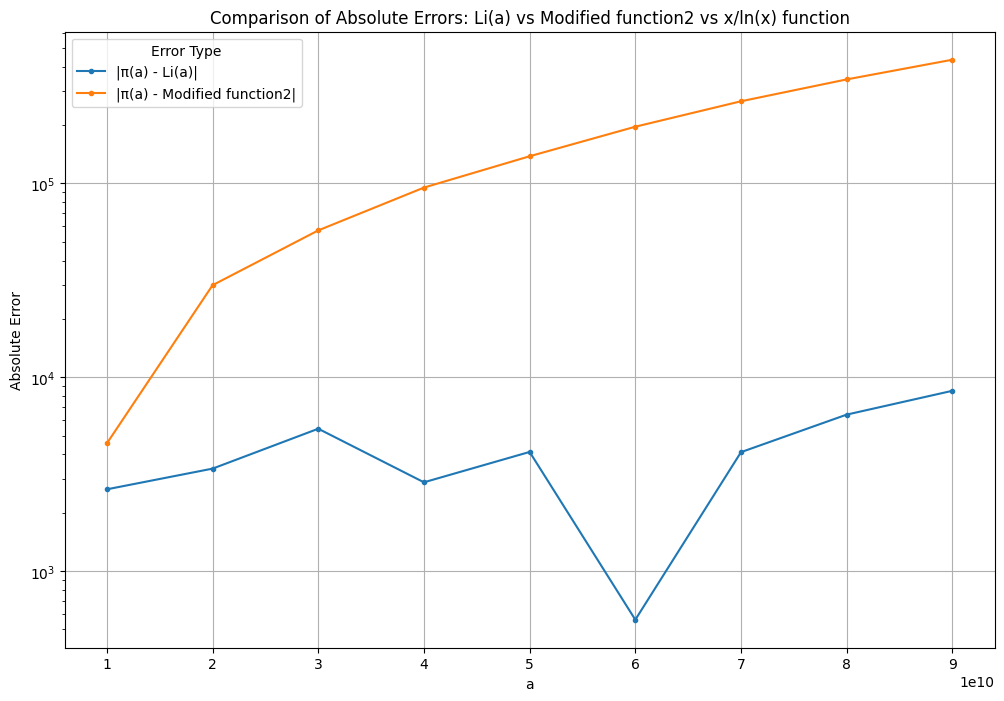

In [22]:
plt.figure(figsize=(12, 8))
plt.semilogy(a_values, mod_errors,marker='.', label='|π(a) - Li(a)|')
plt.semilogy(a_values, mod_errors2,marker='.', label='|π(a) - Modified function2|')
#plt.semilogy(a_values, mod_ln,marker=".", label='|π(a) - x/lnx|')
#plt.semilogy(a_values, mod_ln_ln2,marker=".", label='|π(a) - x/lnx^2|')

plt.title('Comparison of Absolute Errors: Li(a) vs Modified function2 vs x/ln(x) function')
plt.xlabel('a')
plt.ylabel('Absolute Error')
plt.legend(title='Error Type')
plt.grid(True)
# Save the plot as a PNG file
plt.savefig('error_comparison_plot.png', dpi=300, bbox_inches='tight')

# Display the plot (optional, if you're running this in an environment that can show plots)
plt.show()